In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [3]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [4]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [5]:
##Question 1


###1a
features = food.iloc[:, 4:]

###1b
scaler = StandardScaler()
foodscaled = scaler.fit_transform(features)
foodscaled = pd.DataFrame(foodscaled, columns = features.columns)

###1c
num_row = foodscaled.shape[0]
num_col = foodscaled.shape[1]
max_num = foodscaled.max().max()
min_num = foodscaled.min().min()
mean_val = foodscaled.mean().mean()
std_val = foodscaled.std().mean()

#np,std()

print("***")
print("Q1.c: foodscaled matrix details")
print("Number of rows:",num_row)
print("Number of columns:",num_col)
print("Min:", round(min_num,1))
print("Max:", round(max_num,1))
print("Mean:", round(mean_val,1))
print("Standard Deviation:", round(std_val,1))

***
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: -0.0
Standard Deviation: 1.0


C:\Users\Gyu Hwan Park\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gyu Hwan Park\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Variance explained by each PC [0.13310201 0.11808766]


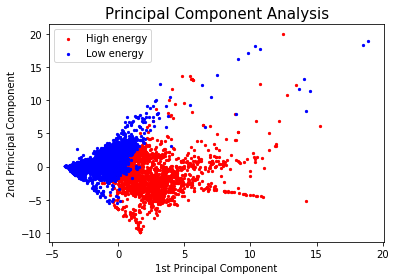

In [6]:
#Question 2

###2a
# create categorising column in the original food column, because adding it to the foodscaled dataframe will have an
# effect in calculating the PCA component values.
food['EnergyLevel'] = np.where(food['Energy, with dietary fibre (kJ)']>1000, 1, 0)

###2b
sklearn_pca = PCA(n_components=2)   #we want just the first two PCs
# compute PC calculation
foodreduced = sklearn_pca.fit_transform(foodscaled)

print("Variance explained by each PC",sklearn_pca.explained_variance_ratio_)   #print out the amount of variance explained by each PC

###2c

# modify foodreduced to a dataframe in order to add the energylevel attribute
foodreduced = pd.DataFrame(foodreduced)
foodreduced['EnergyLevel'] = food['EnergyLevel']

# separate the high and low energy level foods so we can easily graph a scatter plot
food_high=foodreduced.loc[foodreduced['EnergyLevel']==1]
food_low=foodreduced.loc[foodreduced['EnergyLevel']==0]

fig, ax = plt.subplots()

ax.scatter(food_high[0],food_high[1],color='red',label='High energy',s=5)
ax.scatter(food_low[0],food_low[1],color='blue',label='Low energy',s=5)
leg = ax.legend()

plt.xlabel('1st Principal Component', fontsize=10)
plt.ylabel('2nd Principal Component', fontsize=10)
plt.title("Principal Component Analysis", fontsize=15)
plt.show()


Question 2d answer here

The graph produced in c) shows a scatter plot of 1st Principal Component against the 2nd Principal Component of our dataset, colour coded according to the Energy-Level (high or low).

It is observed that most of data points tend to group together with data points from the same Energy-level category. 
Also, it is seen that most of data points are grouped along the Principal Component values of 0 (y and x axis 0), where low energy foods seem more likely to have 1st Principal Component value less than 0, and high energy foods likely to have 1st Principal Component value higher than 0.

The 1st Principal Component captures as much of the variability in the data as possible, and the 2nd Principal Component captures as much of the remaining variability as possible.

PCA is used to reduce the large set of attributes in the original data to a small set that still contains most of the information in the large set.
So the advantage is that we have reduced the complex data into 2 simple components, much easier to visualize and increasing computational efficiency.

We see that there are two Low-energy food outliers in the top right corner of the graph. These 2 foods will have attributes that show distinctly different trends to all other foods.

There is also a High-energy food which has the highest 2nd Principal Component value, this food is likely to be an outlier as well.
So these foods have different trends in the values for the various attributes we have in the data.

A disadvantage of using PCA analysis on this dataset is that it is difficult to interpret the physical meaning of the 2 principal axes.
Also, a limitation exists because PCA analysis always assumes linear independence of variables.

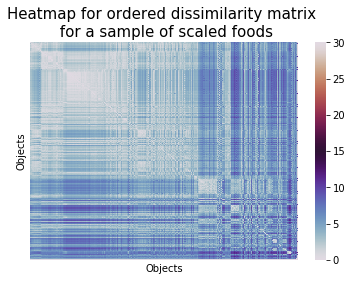

In [7]:
#Question 3


###3a
# change data type of Survey ID column to string and slice the first 2 digits into Food category
food['Survey ID'] = food['Survey ID'].astype(str)
foodscaled['Food category'] = food['Survey ID'].str.slice(0,2)
foodscaled['Food category'] = foodscaled['Food category'].astype(str)


###3b
# create sample row data for foods with Food category values of 13, 20 and 24.
sample13 = foodscaled.loc[foodscaled['Food category'] == '13']
sample20 = foodscaled.loc[foodscaled['Food category'] == '20']
sample24 = foodscaled.loc[foodscaled['Food category'] == '24']
# concatenate above dataframes
foodscaledsample = pd.concat([sample13, sample20, sample24])
# delete the food category attribute since it is not part of the original data
del foodscaledsample['Food category']

###3c

# Apply VAT Algorithm to foodscaedsample dataset, as shown in workshop 6
RV, C, I = VAT(foodscaledsample)


###3d

# visualize the ordered dissimilarity matrix calculated, as shown in workshop 6
x=sns.heatmap(RV,cmap="twilight",xticklabels=False,yticklabels=False, vmin=0, vmax=30)
x.set(xlabel='Objects', ylabel='Objects')
plt.title("Heatmap for ordered dissimilarity matrix \n for a sample of scaled foods", fontsize=15)
plt.show()



Question 3e here


From the heatmap above, 2 clusters are apparent. One at top left corner, and one in bottom right corner.

This is unexpected, since the food sample we have selected consists of 3 different food categories (13, 20 and 24). This means although we expected 3 groups to be present, actually, two of the three categories selected have similar properties, and have been clustered into 1.

The use of different colormaps can play a significant role in producing visualisations of varying usefulness as the inappropriate choice of colormap and the range of colors can make the clusters look ambiguous, even if they exist.
So it is important to use a colormap with suitable range of maximum and minimum color values that allow the clusters to be revealed easily with human eyes.

There are various properties an optimal colormap should have.
One is an appropriate brightness of the overall colour scheme, as it may be unpleasing to look at a very bright colormap for a long time. After all, we use heatmap to visually determine the clusters by inspecting with human eyes.
Secondly, an appropriate range of minimum and maximum colormap values is crucial. Having a range that is too small or too large can have a negative effect on the heatmap and make the cluster determination process very ambiguous. 

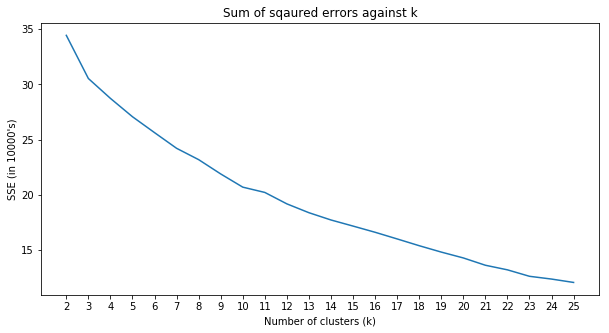

In [8]:
#Question 4

###4a 

# calculating the sse for each k value.
# retrieved from: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
sse = {}
# for use in question 8, we generate the 'Clustering labels' column
foodscaledcopy = foodscaled.copy(deep=True)
foodscaledcopy.insert(len(foodscaledcopy.columns)-1, 'Clusters', '')

for k in range(2, 26):
    kmeans = KMeans(n_clusters=k, random_state=100).fit(foodscaled)
    foodscaledcopy["Clusters"] = kmeans.labels_
    #print(foodscaled["clusters"])
    sse[k] = kmeans.inertia_ /10000 # Inertia: Sum of distances of samples to their closest cluster center
#foodscaled = foodscaled.drop("clusters", axis=1)

plt.figure(figsize=(10,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xticks(range(2,26))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (in 10000's)")
plt.title('Sum of sqaured errors against k')
plt.show()


In [9]:
sse

{2: 34.4370533055443,
 3: 30.52982791872459,
 4: 28.729542378744185,
 5: 27.06693523291972,
 6: 25.62787160468031,
 7: 24.20839678755783,
 8: 23.18172649676285,
 9: 21.88676252751351,
 10: 20.69131360346967,
 11: 20.21213512635571,
 12: 19.176821995688037,
 13: 18.37630956347478,
 14: 17.717611657450227,
 15: 17.165600344557546,
 16: 16.604842590538887,
 17: 16.001436629917226,
 18: 15.388283767125168,
 19: 14.81087869096371,
 20: 14.28035697650472,
 21: 13.618909145765214,
 22: 13.202717943036992,
 23: 12.617941569839903,
 24: 12.367053496888113,
 25: 12.060823988961427}

Question 4b answer here

The shape of the plot from 4a) is like an L shape, sort of like an arm, with the value of SSE generally decreasing as the number of clusters increases. This is inevitable as adding more and more clusters usually decreases the distance of data points from the closest cluster centre, the SSE eventually becoming 0 when we have the number of clusters equal to the number of data points.

So we look for an 'elbow' and at which k value it occurs. With so wide range of k values (2 to 25), it is difficult to really examine this. 

The elbow usually represents where we start to have diminishing returns by increasing k. From the figure, it seems to be that after k=10, the amount of decrease in the SSE starts to diminish.
Therefore, we postulate the appropriate number of clusters to use to be about 3 or 4.
This is not expected as we have so many different types of foods in our dataset, and according to this, we can group all foods in 'foodscaled' in 3 or 4 clusters. However, it is quite difficult to determine this exactly with bare eyeballing.

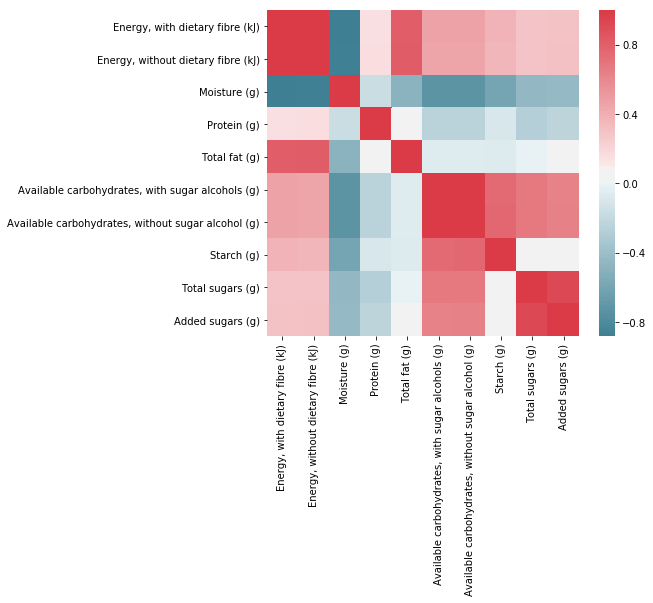

In [10]:
###Question 5

# getting the required columns and calculating the correlation matrix
first10 = food.iloc[:,4:14]
first10_corr= first10.corr()

###5a

fig, ax = plt.subplots(figsize=(7, 6))
y=sns.heatmap(first10_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()


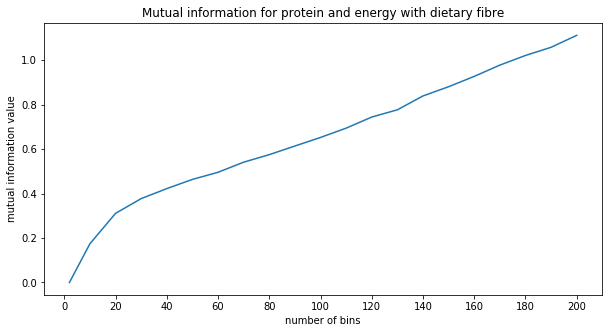

In [11]:
###5b code

# import mutual_info_score to calculate the MI between two clusters
from sklearn.metrics import mutual_info_score

# create a dataframe with only the required attributes
protein_energy = food.loc[:,['Protein (g)', 'Energy, with dietary fibre (kJ)']]

# a function that calculates the MI, given the number of bins and two attributes
def calc_MI(x, y, bins):
    # np.histogram2d generates a 2D histogram with 'bins' equal width bins for x and y.
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# dictionary for storing number of bins and MI values
MI_dict = {}
MI_dict[2] = calc_MI(protein_energy['Protein (g)'], protein_energy['Energy, with dietary fibre (kJ)'], 2)

# complete the dictionary for all other bin legnths
for i in range(10, 201, 10):
    MI_dict[i] = calc_MI(protein_energy['Protein (g)'], protein_energy['Energy, with dietary fibre (kJ)'], i)

# create graph
plt.figure(figsize=(10,5))
plt.plot(list(MI_dict.keys()), list(MI_dict.values()))
plt.title('Mutual information for protein and energy with dietary fibre')
plt.xlabel('number of bins')
plt.xticks(range(0,201,20))
plt.ylabel('mutual information value')
plt.show()


Question 5b comment here

General trend that is seen from the graph above is that mutual information tends to increase as the number of bins increases, for Protein (g) and Energy, with dietary fibre (kJ).
But we also see that until about 20 bins, the mutual information value rises steeply, i.e. the graph has a high slope, and then from 20 bins to 200, the graph flattens a bit and seems pretty linear.

In [12]:
###5c code

# want to only use from Energy, with deitary fibre (kJ) to Total trans fatty acids (mg), excluding EnergyLevel
food53 = food.iloc[:,4:-1]
corr_mat = food53.corr()

corr_list = []
# make corr_list have all values of correlation pairs and sort it in descending order
corr_list += [item for i in corr_mat.values for item in i]
corr_list.sort(reverse=True)
# strip out the first 53 elements as they are all '1's.
corr_list = corr_list[53:]
# delete every second element as they are duplicates because of diagonal symmetry of the correlation matrix.
del(corr_list[::2])

top10_corr=[]
# append the top 10 correlation pairs into top10_corr, using np.argwhere().
for val in corr_list[:10]:
    top10_corr += [(corr_mat.index[x], corr_mat.columns[y], val) for x,y in np.argwhere(corr_mat.values==val)]
# delete every second duplicate elements.
del(top10_corr[::2])

MI_list = []
# iterate over all columns
for i in range(len(food53.columns)):
    # iterate over the columns that are only to the right of the column above, this way we remove duplicate calculations.
    for j in range(i+1, len(food53.columns)):
        # append to MI_list, a list containing the two column names, and the MI value using 20 bins
        MI_list+= [[food53.columns[i], food53.columns[j], calc_MI(food53[food53.columns[i]], food53[food53.columns[j]], 20)]]
# sort MI_list according to the MI value in descending order
MI_list.sort(key=lambda x:x[2], reverse=True)
MI_list10 = MI_list[:10]

print('***')
print('Top 10 feature-pairs for Pearson correlation (highest to lowest)\n')
for i in range(1,11):
    print(str(i)+':', round(top10_corr[i-1][-1],7),top10_corr[i-1][0], ' and ', top10_corr[i-1][1])
    
print('\n\nTop 10 feature-pairs for Mutual Information (highest to lowest)\n')
for i in range(1,11):
    print(str(i)+':', round(MI_list10[i-1][-1],7),MI_list10[i-1][0], ' and ', MI_list10[i-1][1])

***
Top 10 feature-pairs for Pearson correlation (highest to lowest)

1: 0.9995279 Vitamin E (mg)  and  Alpha-tocopherol (mg)
2: 0.9986075 Energy, without dietary fibre (kJ)  and  Energy, with dietary fibre (kJ)
3: 0.9959607 Provitamin A (b-carotene equivalents) (µg)  and  Beta-carotene (µg)
4: 0.9954656 Available carbohydrates, without sugar alcohol (g)  and  Available carbohydrates, with sugar alcohols (g)
5: 0.9888937 Free sugars (g)  and  Added sugars (g)
6: 0.9857627 Dietary folate equivalents  (µg)  and  Total Folates  (µg)
7: 0.9736405 Linoleic acid (g)  and  Total polyunsaturated fat (g)
8: 0.9581122 Dietary folate equivalents  (µg)  and  Folic acid  (µg)
9: 0.9540997 Vitamin A retinol equivalents (µg)  and  Preformed vitamin A (retinol) (µg)
10: 0.9527616 Total long chain omega 3 fatty acids (mg)  and  C22:6w3 Docosahexaenoic (mg)


Top 10 feature-pairs for Mutual Information (highest to lowest)

1: 2.1766557 Energy, with dietary fibre (kJ)  and  Energy, without dietary fibre 

Question 5c comment here

    Similarities
We see that there are some feature-pairs that appear to be in the top 10 for both Pearson correlation and Mutual information. These include:

'Energy, without dietary fibre (kJ)' and 'Energy, with dietary fibre (kJ)', 2nd for both Pearson correlation and 1st for Mutual information,

'Available carbohydrates, without sugar alcohol (g)' and 'Available carbohydrates, with sugar alcohol (g)', 4th for Pearson correlation and 2nd for Mutual information,

'Free sugars (g)' and 'Added sugars (g)', 5th for Pearson correlation and 6th for Mutual information.

So these attributes are highly likely to be 'dependent' feature-pairs.

    Differences
There are some feature-pairs that only appear in one ranking, and not the other. These include, 

    for Pearson correlation (but not in Mutual information):

'Vitamin E (mg)'  and  'Alpha-tocopherol (mg)', 1st,

'Provitamin A (b-carotene equivalents) (µg)'  and  'Beta-carotene (µg)', 3rd,

'Dietary folate equivalents  (µg)'  and  'Total Folates  (µg)', 6th,

'Linoleic acid (g)'  and  'Total polyunsaturated fat (g)', 7th,

'Dietary folate equivalents  (µg)'  and  'Folic acid  (µg)', 8th,

'Vitamin A retinol equivalents (µg)'  and  'Preformed vitamin A (retinol) (µg)', 9th,

'Total long chain omega 3 fatty acids (mg)'  and  'C22:6w3 Docosahexaenoic (mg)', 10th.



    for Mutual information (but not in Pearson correlation):

'Energy, with dietary fibre (kJ)'  and  'Moisture (g)', 3rd,

'Energy, without dietary fibre (kJ)'  and  'Moisture (g)', 4th,

'Protein (g)'  and  'Tryptophan (mg)', 5th,

'Available carbohydrates, without sugar alcohol (g)'  and  'Total sugars (g)', 7th,

'Available carbohydrates, with sugar alcohols (g)'  and  'Total sugars (g)', 8th,

'Total sugars (g)  and  Free sugars (g)', 9th,

'Energy, with dietary fibre (kJ)  and  Total fat (g)', 10th.






***
Q6.a: Train Test Split Results
X_train matrix: 4592 x 53
y_train labels: 4592 x 1
X_test matrix: 1148 x 53
y_test labels: 1148 x 1
***


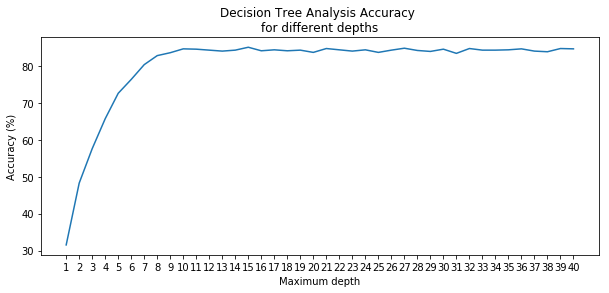

In [13]:
##Question 6

###6a

X_train, X_test, y_train, y_test = train_test_split(foodscaled.iloc[:,:-1], foodscaled.iloc[:,-1:], test_size=0.2)
print("***")
print("Q6.a: Train Test Split Results")
print("X_train matrix:", X_train.shape[0],"x",X_train.shape[1])
print("y_train labels:", y_train.shape[0],"x",y_train.shape[1])
print("X_test matrix:", X_test.shape[0],"x",X_test.shape[1])
print("y_test labels:", y_test.shape[0],"x",y_test.shape[1])
print("***")

###6b

def calc_acc(training_data, training_label, test_data, test_label, depth):
    dt_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    dt_entropy.fit(training_data, training_label)
    y_pred = dt_entropy.predict(test_data)
    acc = accuracy_score(test_label, y_pred)*100
    return acc

# dictionary for storing max_depth and accuracy values
acc_dict = {}

# complete the dictionary for max_depth values from 1 to 40.
for i in range(1, 41):
    acc_dict[i] = calc_acc(X_train, y_train, X_test, y_test, i)

# create graph
plt.figure(figsize=(10,4))
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.title('Decision Tree Analysis Accuracy \nfor different depths')
plt.xlabel('Maximum depth')
plt.xticks(range(1,41))
plt.ylabel('Accuracy (%)')
plt.show()


Question 6c comment here

Looking at the graph above, we can see that accuracy increases steeply from maximum depth of 1 to about 8, then it starts to settle down around 90% for the rest of maximum depth values.

Local peaks after about maximum depth of 8 occur randomly. This is because the decision tree is run randomly, without a specific seed given.

In [14]:
#Question 7

###7a

# apply the k-NN algorithm with number of neighbors = 1.
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, np.ravel(y_train))
y_pred_train=knn1.predict(X_train)
y_pred_test=knn1.predict(X_test)

print("***")
print("Q7.a: Food category prediction using k-NN (k=1)")
print("Train accuracy:", round(accuracy_score(y_train, y_pred_train)*100, 1),'%')
print("Test accuracy:", round(accuracy_score(y_test, y_pred_test)*100, 1),'%')
print("***")

# to use this in question 8, comparing with the newly selected features
knn1_comparison = accuracy_score(y_test, y_pred_test)*100

##7b

# apply the k-NN algorithm with number of neighbors = 3.
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, np.ravel(y_train))
y_pred_train3=knn3.predict(X_train)
y_pred_test3=knn3.predict(X_test)

print("\n***")
print("Q7.b: Food category prediction using k-NN (k=3)")
print("Train accuracy:", round(accuracy_score(y_train, y_pred_train3)*100, 1),'%')
print("Test accuracy", round(accuracy_score(y_test, y_pred_test3)*100, 1),'%')
print("***")

# to use later in question 8. This will be the benchmark for choosing our n value.
knn3_comparison = accuracy_score(y_test, y_pred_test3)*100


***
Q7.a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 89.3 %
***

***
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy: 93.4 %
Test accuracy 86.8 %
***


Question 7c comment here

We see that the test accuracy for k-NN predictions with k=1 and k=3 are 92.9% and 91.5% respectively.
For the training set, k-NN (k=1) has an accuracy of 100% and k-NN (k=3) having 95.9 %.

Train accuracy for prediction using k=1 is higher since when you use k-NN algorithm with k=1, i.e. 1 nearest neighbor, the 'nearest neighbor' will be the point itself. So this results in 100% train accuracy.

Question 7d comment here 

Normalization in Question 1 made the values of all data points be closer together, centred around 0. So we inevitably have closer neighbors than the original which can affect the k-NN method.
We can use the original 'food' dataframe to address this issue, the one that has not been normalized.



In [15]:
#Question 8 code
import itertools # use for generating features

## Generating interaction term pairs, we need to find which pairs to use to generate the new features.

# First we find the mutual information value of all features with respect to Food category.
foodscaled['Food category'] = foodscaled['Food category'].astype(float)
foodscaledcopy['Food category'] = foodscaledcopy['Food category'].astype(float)

new_MI_list = []
# iterate over all columns except for the class column
for i in range(len(foodscaled.columns)-1):
    # append to new_MI_list, a list containing the MI value using 20 bins and the feature name
    new_MI_list+= [[foodscaled.columns[i], calc_MI(foodscaled[foodscaled.columns[i]], foodscaled['Food category'], 20)]]
# sort new_MI_list according to the MI value in descending order
new_MI_list.sort(key=lambda x:x[1], reverse=True)
# get top 6 MI ranking
new_MI_list = new_MI_list[:6]

top6_MI = []
print('\n\nTop 6 features for Mutual Information (20 bins) with Food category, from original foodscaled\n')
for i in range(1,7):
    print(str(i)+':', round(new_MI_list[i-1][-1],7),new_MI_list[i-1][0])
    top6_MI.append(new_MI_list[i-1][0])

# we select 2 pairs each time from the top 6 MI ranking, so we get 15 new features (6 combination 2). 
# we use the multiplication method.
pairs = []

# please note that the code below (for loop) raises error if this cell is run more than once.
# This is because we try to create columns that have already been created.
i=-1
# running combinations from our top6 MI ranking
for subset in itertools.combinations(top6_MI, 2):
    i +=1
    # create the name of the interaction term pair as an element in the list 'pairs'
    pairs.append("pair_{}".format(subset[0]+subset[1]))
    # create new series using the multiplication methods for the chosen pair
    new_col=pd.Series(foodscaledcopy[subset[0]]*foodscaledcopy[subset[1]])
    # insert into dataframe with correct column name
    foodscaledcopy.insert(len(foodscaledcopy.columns)-2, pairs[i], new_col)

# we now have 70 columns, originally 54 including Food category, + 1 for Clusters, + 15 for interaction term pairs
# run the MI ranking again, to select the top 'n' features from the 70. (so 69 attribute columns)
selection = []
# iterate over all columns except for the class column
for i in range(len(foodscaledcopy.columns)-1):
    # append to selection, a list containing the MI value using 20 bins and the feature name
    selection+= [[foodscaledcopy.columns[i], calc_MI(foodscaledcopy[foodscaledcopy.columns[i]], foodscaledcopy['Food category'], 20)]]
# sort selection according to the MI value in descending order
selection.sort(key=lambda x:x[1], reverse=True)

# create a new dataframe which will contain features in a sorted order, by MI value with Food category
feat_select = pd.DataFrame([])
print('\n\nFeature rankings for Mutual Information (20 bins) with Food category, including new features\n')
for i in range(1,len(foodscaledcopy.columns)):
    print(str(i)+':', round(selection[i-1][-1],7),selection[i-1][0])
    feat_select[selection[i-1][0]] = foodscaledcopy[selection[i-1][0]]
    
# we now have new, sorted dataframe, features of highest MI rankings with respect to Food category appearing first
feat_select['Food category'] = foodscaledcopy['Food category']




Top 6 features for Mutual Information (20 bins) with Food category, from original foodscaled

1: 0.5774268 Moisture (g)
2: 0.5026797 Energy, with dietary fibre (kJ)
3: 0.4925972 Energy, without dietary fibre (kJ)
4: 0.484904 Protein (g)
5: 0.4659945 Available carbohydrates, with sugar alcohols (g)
6: 0.4564697 Available carbohydrates, without sugar alcohol (g)


Feature rankings for Mutual Information (20 bins) with Food category, including new features

1: 1.3337502 Clusters
2: 0.5774268 Moisture (g)
3: 0.5026797 Energy, with dietary fibre (kJ)
4: 0.4925972 Energy, without dietary fibre (kJ)
5: 0.484904 Protein (g)
6: 0.4659945 Available carbohydrates, with sugar alcohols (g)
7: 0.4564697 Available carbohydrates, without sugar alcohol (g)
8: 0.4361966 pair_Protein (g)Available carbohydrates, without sugar alcohol (g)
9: 0.4347622 pair_Energy, without dietary fibre (kJ)Available carbohydrates, without sugar alcohol (g)
10: 0.4344191 pair_Moisture (g)Available carbohydrates, without s

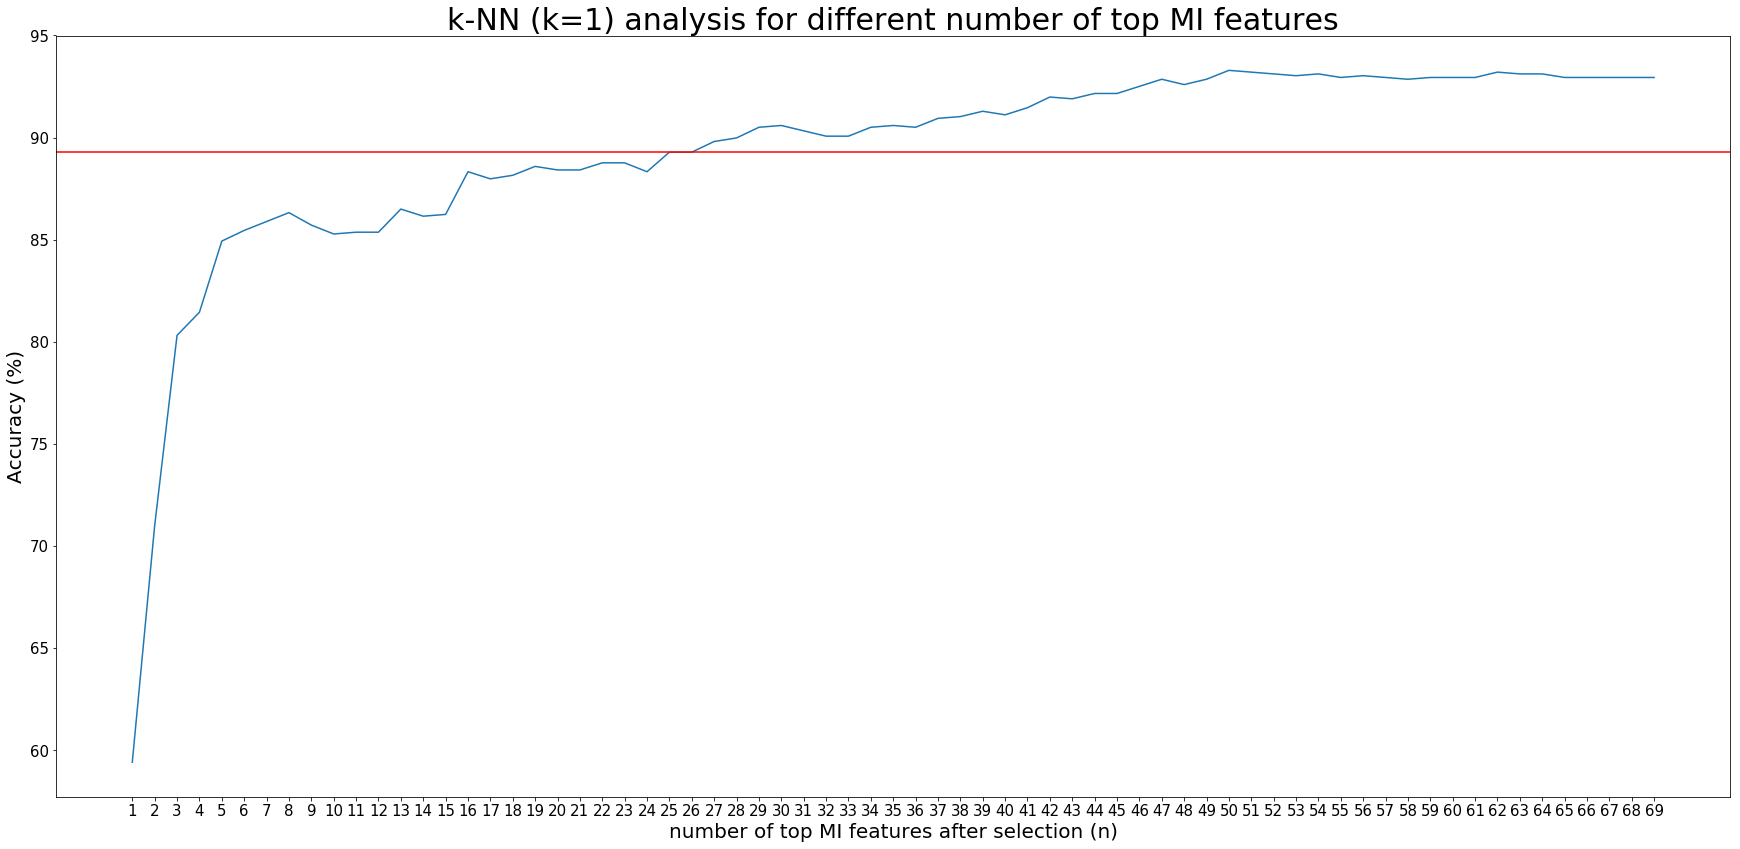

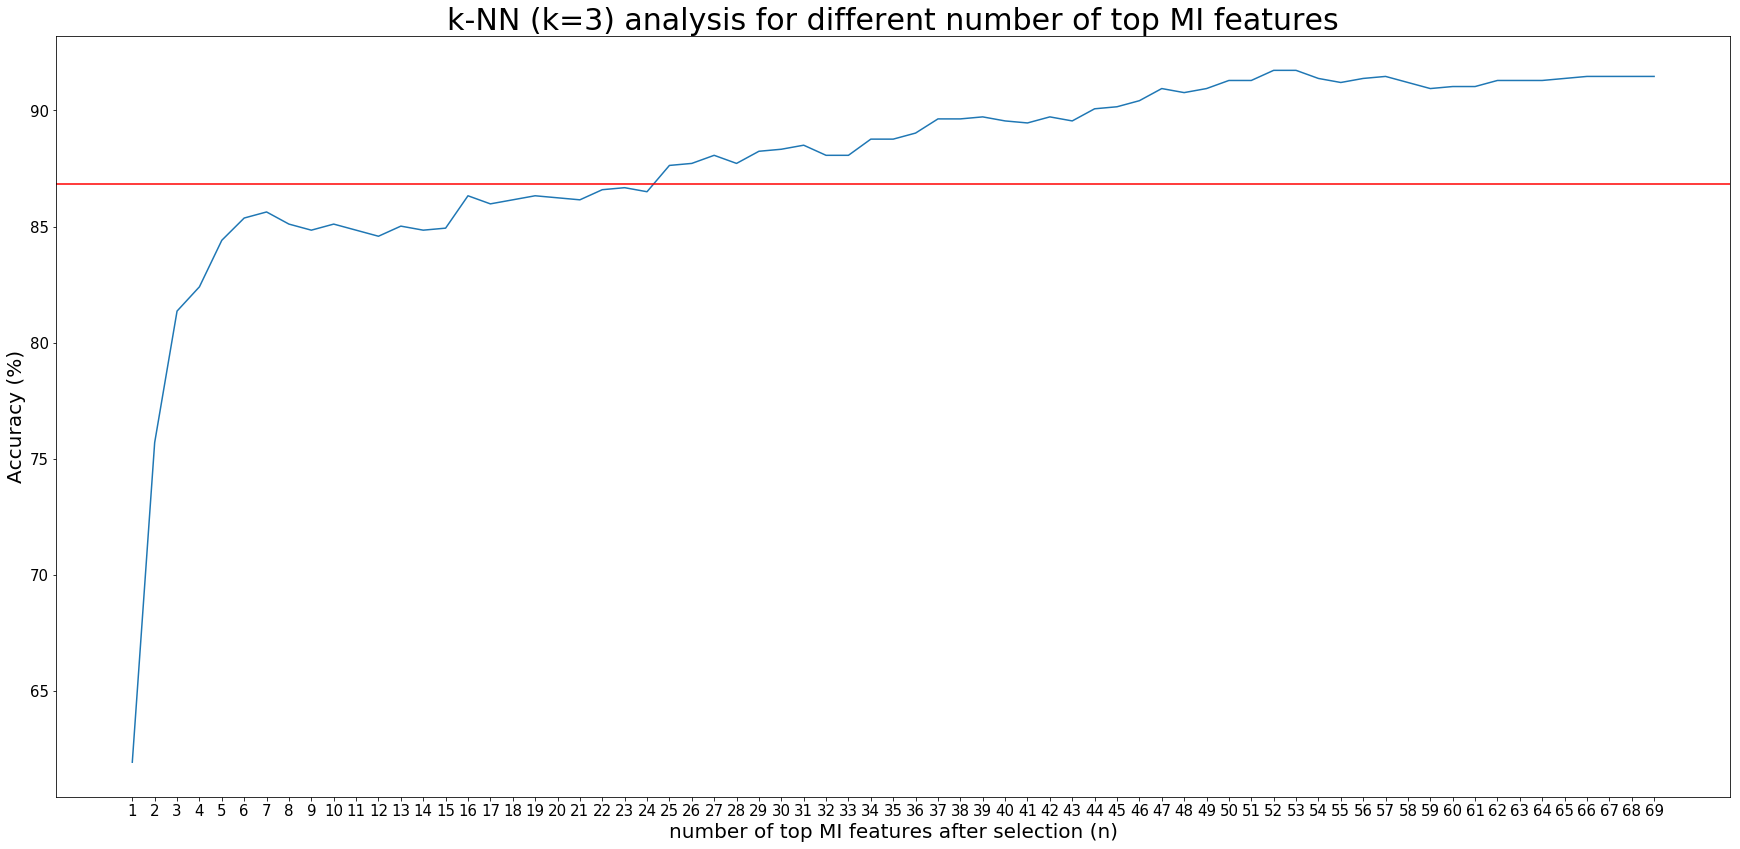

In [16]:
# create dictionaries to store the accuracy values and the corresponding number of features used, for k-NN (k=1 and k=3).
knn1_dict={}
knn3_dict={}

# consider until the column before food category
for n in range(0,69):
    # create train, test sets
    X_train, X_test, y_train, y_test = train_test_split(feat_select.iloc[:,:n+1], feat_select.iloc[:,-1:], test_size=0.2, random_state=100)

    # apply the k-NN algorithm with number of neighbors = 1.
    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn1.fit(X_train, np.ravel(y_train))
    y_pred_test=knn1.predict(X_test)
    knn1_dict[n+1] = (accuracy_score(y_test, y_pred_test))*100
    

    # apply the k-NN algorithm with number of neighbors = 3.
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn3.fit(X_train, np.ravel(y_train))
    y_pred_test=knn3.predict(X_test)
    knn3_dict[n+1] = (accuracy_score(y_test, y_pred_test))*100

# plot the graph for k-NN with k=1 
plt.figure(figsize=(30,14))
plt.plot(list(knn1_dict.keys()), list(knn1_dict.values()))
# this sets a comparison horizontal line. This line represents the accuracy value when the original foodscaled was used.
plt.axhline(y=knn1_comparison, color='r', linestyle='-')
plt.title('k-NN (k=1) analysis for different number of top MI features', fontsize=30)
plt.xlabel('number of top MI features after selection (n)', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.xticks(range(1,70), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# plot the graph for k-NN with k=3
plt.figure(figsize=(30,14))
plt.plot(list(knn3_dict.keys()), list(knn3_dict.values()))
# as explained above, sets a comparison line
plt.axhline(y=knn3_comparison, color='r', linestyle='-')
plt.title('k-NN (k=3) analysis for different number of top MI features', fontsize=30)
plt.xlabel('number of top MI features after selection (n)', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.xticks(range(1,70), fontsize=15)
plt.yticks(fontsize=15)
plt.show()  

In [17]:
# create a function that extracts a key, which has the value same as the search value inputted.
def find_key(dic,search):
    for key,val in dic.items():
        if val == search:
             return key
# use find_key to find the number of features used when maximum accuracy occurs
max_acc_knn1 = find_key(knn1_dict, max(knn1_dict.values()))
max_acc_knn3 = find_key(knn3_dict, max(knn3_dict.values()))
n= int(round((max_acc_knn1+max_acc_knn3)/2,0))
print("***")
print("For k-NN when k=1, maximum accuracy {}% occurs when top {} features are used.".format(round(max(knn1_dict.values()),4),max_acc_knn1))
print("For k-NN when k=3, maximum accuracy {}% occurs when top {} features are used.".format(round(max(knn3_dict.values()),4),max_acc_knn3))
print("So we should use k-value of {}, which is the rounded up average of the 2 values above.".format(n))


# now we train and run the k-NN prediction model again with the chosen n value and (k=1) amd (k=3) to check improvement.

X_train, X_test, y_train, y_test = train_test_split(feat_select.iloc[:,:n+1], feat_select.iloc[:,-1:], test_size=0.2, random_state=100)

# apply the k-NN algorithm with number of neighbors = 1.
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, np.ravel(y_train))
y_pred_test=knn1.predict(X_test)
accuracy1 = (accuracy_score(y_test, y_pred_test))*100

# apply the k-NN algorithm with number of neighbors = 3.
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, np.ravel(y_train))
y_pred_test=knn3.predict(X_test)
accuracy3 = (accuracy_score(y_test, y_pred_test))*100

print("\n\nFood category prediction using k-NN (k=1) with n = {}".format(n))
print("Test accuracy:", round(accuracy1, 1),'%')

print("\nFood category prediction using k-NN (k=3) with n = {}".format(n))
print("Test accuracy:", round(accuracy3, 1),'%')
print("***")


***
For k-NN when k=1, maximum accuracy 93.2927% occurs when top 50 features are used.
For k-NN when k=3, maximum accuracy 91.7247% occurs when top 52 features are used.
So we should use k-value of 51, which is the rounded up average of the 2 values above.


Food category prediction using k-NN (k=1) with n = 51
Test accuracy: 93.1 %

Food category prediction using k-NN (k=3) with n = 51
Test accuracy: 91.7 %
***


Question 8 discussion here


For Question 8, I have calculated the accuracy score on the 20% test dataset for all possible values of n, from 1 to 69.
The test data set was created by using the train_test_split() function used before. The training and test sets were created from the new data including new columns (attributes generated).

Then, I calculated the test accuracy for k-NN prediction for (k=1) and (k=3), and plotted the graphs of accuracy vs n. The red horizontal line, which represents the test accuracy on original data calculated in question 7 was also added for reference. We choose the value of n that gives a higher accuracy than the red line. This means our feature generation process has increased the accuracy of prediction for some values of n.

I then averaged the two n values which gave maximum accuracy for k-NN predictions with (k=1) and (k=3). Usually these 2 values will be quite similar. The averaging process is to consider both k values. 
Test accuracy for k-NN prediction with (k=1) and (k=3) are calculated again, using best 'n'. We see that these percentages have significantly increased from Question 7, where we used the raw original data.

So with such evidence discussed, my feature generation-selection process has delivered an accuracy boost.